# (84100) Farnocchia orbit determination test

In [1]:
import grss
prop = grss.prop
fit = grss.fit

In [2]:
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)
import matplotlib.pyplot as plt

In [3]:
body_id = '84100'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
body_radius = 0.0
de_kernel = 441
de_kernel_path = grss.utils.default_kernel_path(de_kernel)

In [4]:
add_gaia_obs = True
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias = False
debias_lowres = True
deweight = True
eliminate = False
max_obs_per_night = 4
verbose = True
obs_array_optical, observer_codes_optical = fit.get_mpc_optical_obs_array(body_id, optical_obs_file, t_min_tdb, t_max_tdb, debias, debias_lowres, deweight, eliminate, max_obs_per_night, verbose)
obs_array_radar, observer_codes_radar = fit.get_radar_obs_array(body_id, t_min_tdb, t_max_tdb, verbose)
if add_gaia_obs:
    obs_array_gaia, observer_codes_gaia = fit.get_gaia_optical_obs_array(body_id, de_kernel_path, t_min_tdb=None, t_max_tdb=None, verbose=True)
    obs_array_optical = np.vstack((obs_array_optical, obs_array_gaia))
    observer_codes_optical = observer_codes_optical + observer_codes_gaia

Skipped 21 observations 
	 21 of which were non-geocentric occultations or space-based observations, 
	 0 were either roving or radar observations (radar is handled separately), 
	 0 of which were outside the specified time range.
No debiasing needed for 505 observations. Debiased 417 observations. No biasing information for 0 observations.
Applied default weight of 1 arcsec to 38 CCD observations
Deweighted 208 observations as part of deweighting scheme.
Found 111 observations from Gaia DR3.
	 Added 17 of those observations.


In [5]:
n_iter_max = 10
fit_sim = fit.FitSimulation(init_sol, init_cov, obs_array_optical, observer_codes_optical, obs_array_radar, observer_codes_radar, n_iter_max=n_iter_max, de_kernel=de_kernel, de_kernel_path=de_kernel_path, radius=body_radius, nongrav_info=nongrav_info)

In [6]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared
1			 0.425			 0.537			 521.971			 0.279
2			 0.425			 0.536			 522.034			 0.279
3			 0.425			 0.536			 522.034			 0.279
Converged without rejecting outliers. Starting outlier rejection now.
4			 0.398			 0.502			 452.977			 0.243
5			 0.398			 0.502			 452.985			 0.243
Converged after rejecting outliers.


In [7]:
fit_sim.print_summary()

Summary of the orbit fit calculations at iteration 5 (of 5):
RMS unweighted: 0.3977177469979497
RMS weighted: 0.5015272873677707
chi-squared: 452.98471812216985
reduced chi-squared: 0.24301755264064906
square root of reduced chi-squared: 0.49296810509468975
t: MJD 58005.0 TDB
Fitted Variable		Initial Value			Uncertainty			Fitted Value 			Uncertainty			Change				Change (sigma)
e			2.02873972465e-01		8.68599899075e-09 		2.02873968805e-01		8.62077243651e-09 		-3.66038030442e-09		-0.421
q			2.17589058084e+00		2.17699673927e-08 		2.17589058977e+00		2.17522243316e-08 		+8.92666607299e-09		+0.410
tp			5.74183073230e+04		2.22097535155e-05 		5.74183073049e+04		2.19858434903e-05 		-1.80255374289e-05		-0.812
om			1.52357220932e+02		5.24227539771e-06 		1.52357219631e+02		5.23708275070e-06 		-1.30123333975e-06		-0.248
w			2.08340003612e+02		8.22401779928e-06 		2.08339999754e+02		8.17538515233e-06 		-3.85827030414e-06		-0.469
i			5.81863313345e+00		9.87617099651e-07 		5.81863359230e+00		9.8393633626

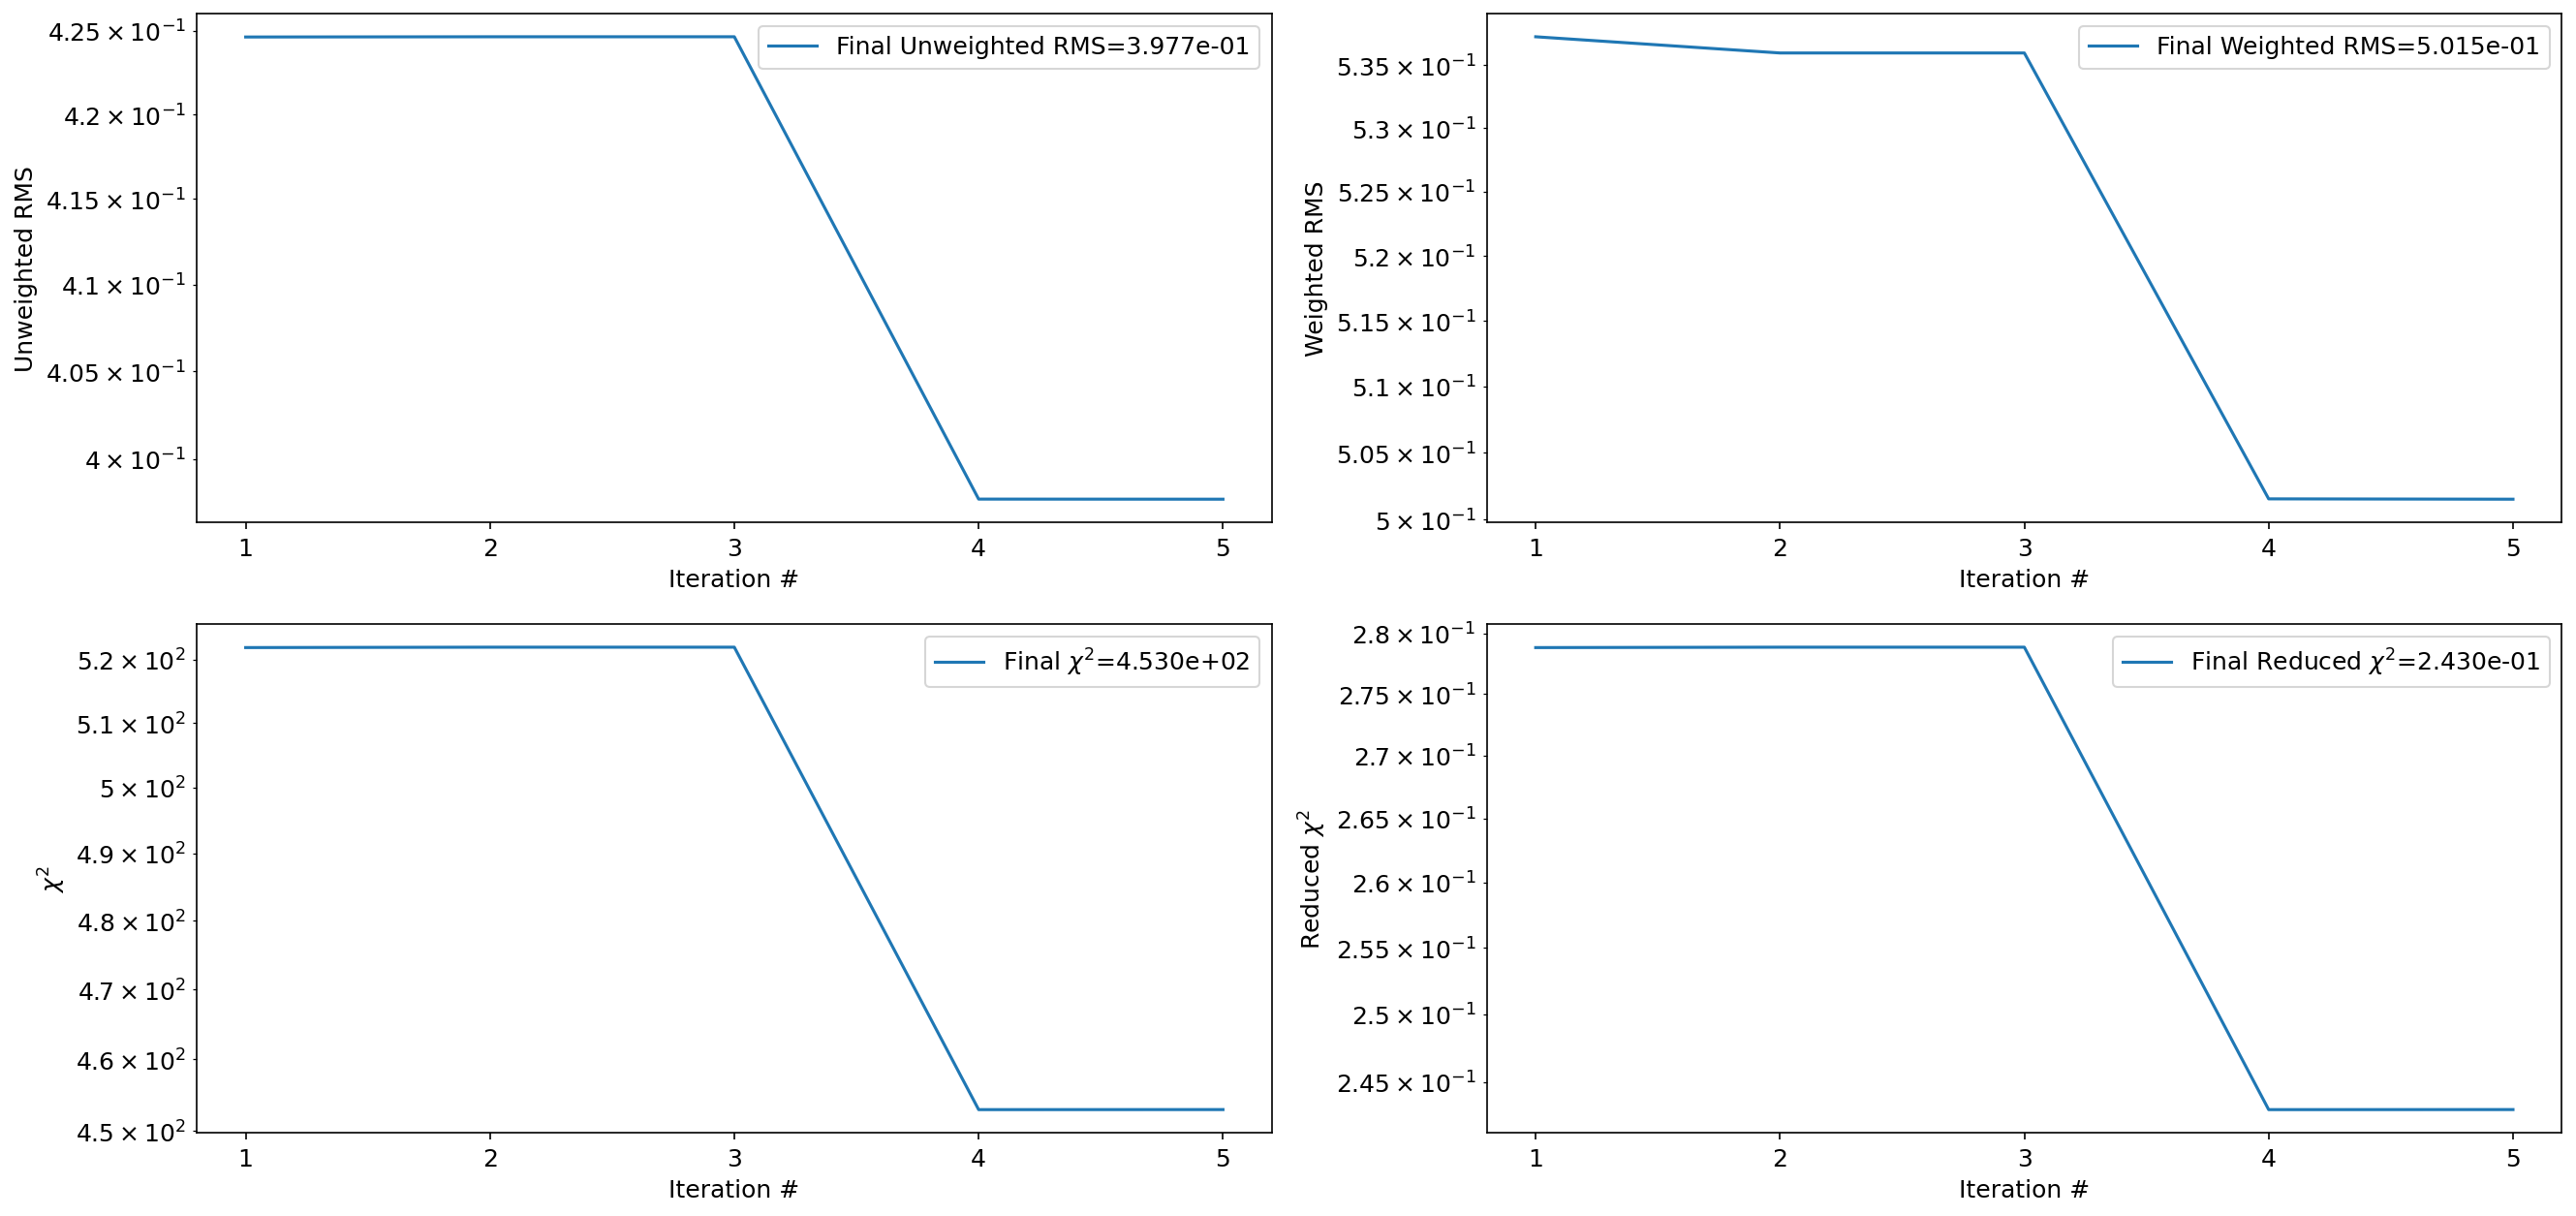

In [8]:
fit_sim.plot_summary(auto_close=True)

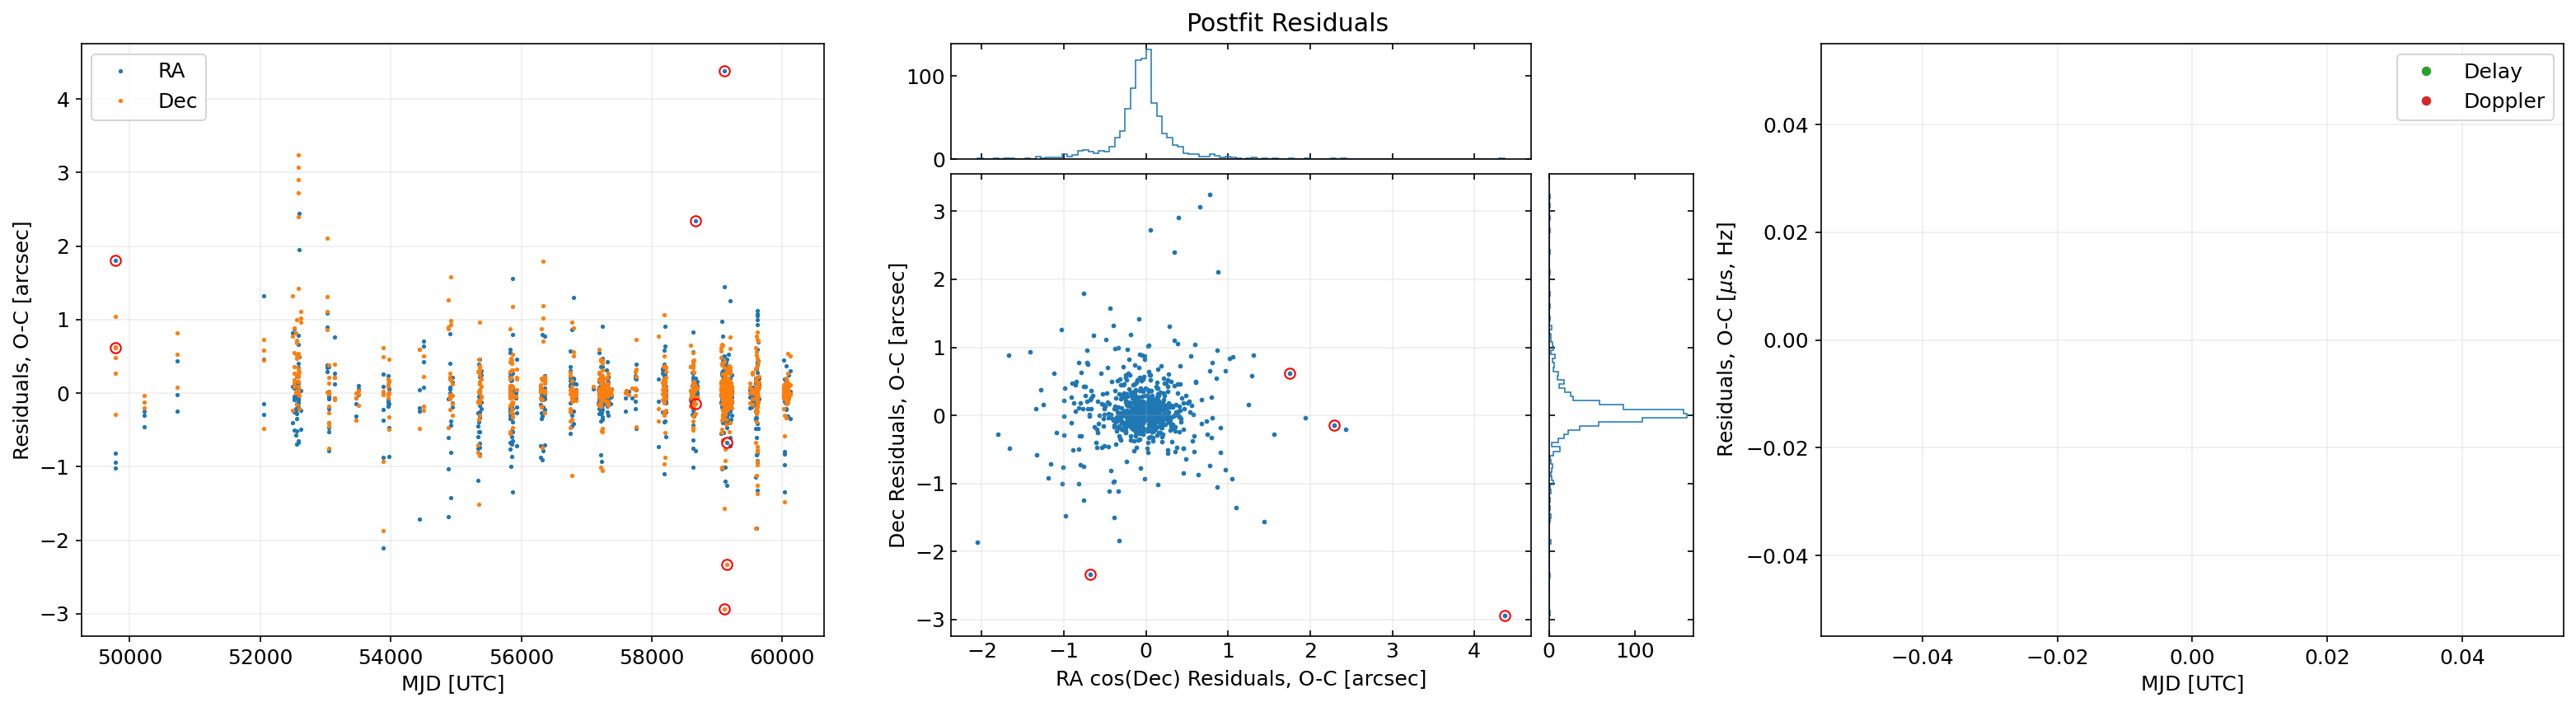

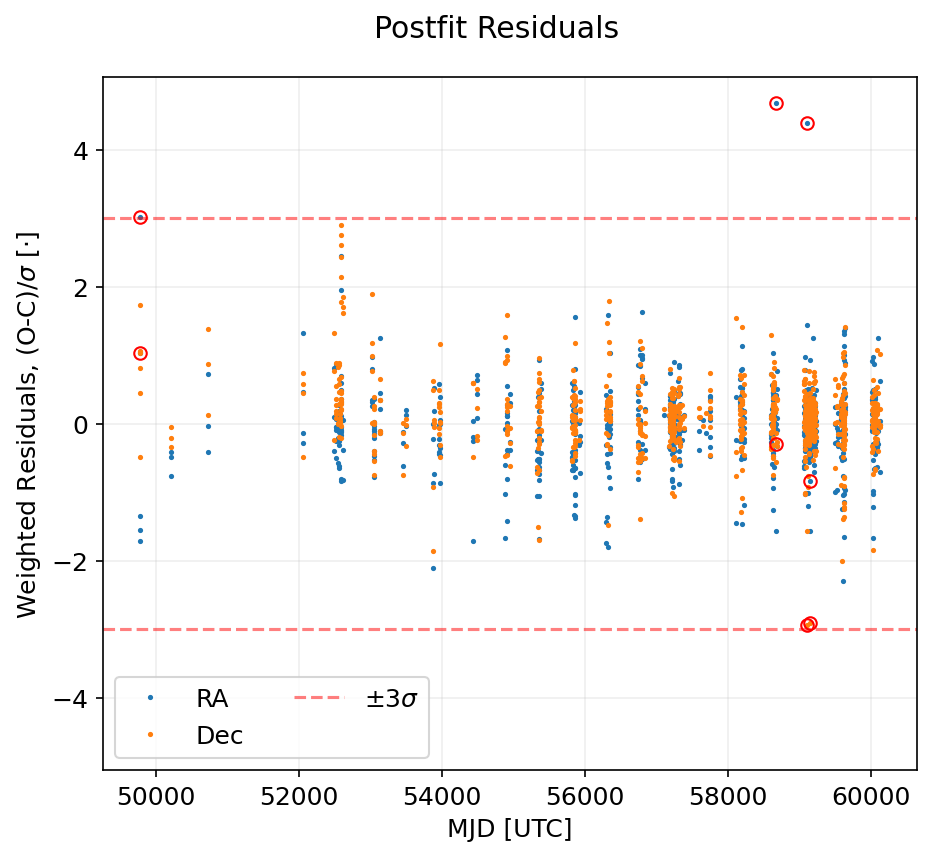

In [9]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [10]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 1.66
Mahalonobis distance between GRSS and JPL solution: 1.66
Bhattacharya distance between JPL and GRSS solution: 0.0002
Bhattacharya coefficient between JPL and GRSS solution: 0.9998


In [11]:
def test_farnocchia():
    assert maha_dist_f < 5.0
    assert maha_dist_0 < 5.0
    assert bhattacharya < 0.10
    assert bhatt_coeff > 0.90